In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
import numpy as np
import pickle
import gzip
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

2025-04-08 10:14:44.811096: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744125285.782299     511 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744125285.970259     511 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744125287.648965     511 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744125287.648997     511 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1744125287.649000     511 computation_placer.cc:177] computation placer alr

In [9]:
class CustomModel:
    def __init__(self, n, k, m):
        self.n = n
        self.k = k
        self.m = m

        self.P_matrices = None
        self.m_heights = None
        self.P_matrices_train = None
        self.P_matrices_test = None
        self.P_matrices_val = None
        self.m_heights_train = None
        self.m_heights_test = None
        self.m_heights_log_train = None
        self.m_heights_log_test = None
        self.m_heights_log_val = None
        self.eval_inputs = None
        self.eval_outputs = None
        self.P_matrices_train_aug = None
        self.m_heights_log_train_aug = None

        self.train_dataset = None
        self.val_dataset = None

        self.model_name = f'model_{self.n}_{self.k}_{self.m}.keras'
        self.model = None
        self.history = None
    def load_and_preprocess_data(self,filepath):
        with gzip.open(filepath, 'rb') as f:
            dataset = pickle.load(f)

        self.P_matrices = []
        self.m_heights = []

        for row in dataset:
            # Remove the last `inf`, this is an error due to bug in the dataset generation
            m_height = row['m_heights'][self.m-1]
            # if len(heights) != 1:
            #     continue
            if m_height == float('inf') or m_height <= 0:
                continue
            # Convert m-heights to log scale
            # log_heights = np.log(heights)
            P_matrix = np.array(row['P_matrix'], dtype=np.float32)

            self.P_matrices.append(P_matrix)
            # m_heights.append(log_heights)
            self.m_heights.append(m_height)
        self.P_matrices = np.array(self.P_matrices, dtype=np.float32)
        self.m_heights = np.array(self.m_heights, dtype=np.float32)
        print("P_matrices shape:", self.P_matrices.shape)
        print("m_heights shape:", self.m_heights.shape)
        # pritnt range of all m-heights
        print("Range of actual m_height:")
        print("Min:", np.min(self.m_heights, axis=0))
        print("Max:", np.max(self.m_heights, axis=0))

    def generate_permuted_dataset(self, P_matrices, m_heights, num_permutations=3):
        """Create augmented dataset by permuting columns of P_matrices."""
        augmented_P_matrices = []
        augmented_m_heights = []

        for i in range(len(P_matrices)):
            original = P_matrices[i]
            target = m_heights[i]

            # Keep original
            augmented_P_matrices.append(original)
            augmented_m_heights.append(target)

            # Generate random permutations
            for _ in range(num_permutations):
                permuted = original[:, np.random.permutation(original.shape[1])]
                augmented_P_matrices.append(permuted)
                augmented_m_heights.append(target)
        return np.array(augmented_P_matrices), np.array(augmented_m_heights)
    def train_test_val_split(self, val_split=0.2, test_split=0.2, num_permutations=4, batch_size=128, random_state=2342):

        if(self.P_matrices is None or self.m_heights is None):
            raise ValueError("Data not loaded. Please load the data first.")
        # Train-test split
        self.P_matrices_train, self.P_matrices_test,\
              self.m_heights_train, self.m_heights_test\
                 = train_test_split(self.P_matrices, self.m_heights, test_size=test_split, random_state=random_state)

        # Converting test set to evaluator format
        self.eval_inputs = {}
        self.eval_outputs = {}

        # Iterate through each P_matrix and corresponding m_heights in test_dataset
        for i in range(len(self.P_matrices_test)):
            P_matrix = self.P_matrices_test[i]
            m_height = self.m_heights_test[i]
            # for m in range(2, self.max_m_value + 1):  # m ranges from 2 to max_m_value
            key = f"[{self.n},{self.k},{self.m}]"

            # Add the P_matrix to the inputs dictionary
            if key not in self.eval_inputs:
                self.eval_inputs[key] = []
            self.eval_inputs[key].append(P_matrix)

            # Add the corresponding m_height to the outputs dictionary
            if key not in self.eval_outputs:
                self.eval_outputs[key] = []
            self.eval_outputs[key].append(m_height)

        # Change m_heights_train and m_heights_test to log_scale
        self.m_heights_log_train = np.log(self.m_heights_train)
        self.m_heights_log_test = np.log(self.m_heights_test)
        print("Range of log m_height:")
        print("Min:", np.min(self.m_heights_log_train, axis=0))
        print("Max:", np.max(self.m_heights_log_train, axis=0))
        # Train-validation split
        self.P_matrices_train, self.P_matrices_val, self.m_heights_log_train, self.m_heights_log_val = train_test_split(self.P_matrices_train, self.m_heights_log_train, test_size=val_split, random_state=random_state)
        # print("test 1")
        # Generate augmented  training dataset
        self.P_matrices_train_aug, self.m_heights_log_train_aug = self.generate_permuted_dataset(self.P_matrices_train, self.m_heights_log_train, num_permutations=num_permutations)
        # print("test 2")
        # Create TensorFlow datasets
        self.train_dataset = tf.data.Dataset.from_tensor_slices((self.P_matrices_train_aug, self.m_heights_log_train_aug))
        self.train_dataset = self.train_dataset.shuffle(self.P_matrices_train_aug.shape[0]).batch(batch_size).prefetch(tf.data.AUTOTUNE)

        self.val_dataset = tf.data.Dataset.from_tensor_slices((self.P_matrices_val, self.m_heights_log_val))
        self.val_dataset = self.val_dataset.shuffle(self.P_matrices_val.shape[0]).batch(batch_size).prefetch(tf.data.AUTOTUNE)
        print("Train dataset shape:", self.P_matrices_train_aug.shape, self.m_heights_log_train_aug.shape)
        print("Validation dataset shape:", self.P_matrices_val.shape, self.m_heights_log_val.shape)
        print("Test dataset shape:", self.P_matrices_test.shape, self.m_heights_log_test.shape)

    def model_compile(self, build_model, print_summary=False):
        if self.train_dataset is None or self.val_dataset is None:
            raise ValueError("Train and validation datasets not created. Please create them first.")
        self.model = build_model(self.n, self.k)
        print("Model compiled.")
        if print_summary:
            self.model.summary()

    def model_train(self, epochs=10, verbose=0, patience=5 , model_save_directory="."):
        if self.model is None:
            raise ValueError("Model not built. Please build the model first.")

        # Early stopping callback
        early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
        model_checkpoint = tf.keras.callbacks.ModelCheckpoint(model_save_directory + '/' + self.model_name, save_best_only=True)
        # Train the model
        self.history = self.model.fit(
            self.train_dataset,
            validation_data=self.val_dataset,
            epochs=epochs,
            callbacks=[
                early_stopping,
                model_checkpoint,
            ],
            verbose=verbose
        )
    def plot_history(self):
        if self.history is None:
            raise ValueError("Model not trained. Train the model first.")
        history_dict = self.history.history
        mse = history_dict["loss"]
        val_mse = history_dict["val_loss"]
        epochs = range(1, len(mse) + 1)
        print('Train MSE :', mse)
        print('Validation MSE :', val_mse)
        plt.plot(epochs, mse, "bo", label="Training mse")
        plt.plot(epochs, val_mse, "b", label="Validation mse")
        plt.title("Training and validation mean squared error")
        plt.xlabel("Epochs")
        plt.ylabel("MSE")
        plt.legend()
        plt.show()
    def evaluate_model(self, batch_size=128):
        if self.history is None:
            raise ValueError("Model not trained. Train the model first.")
        results = self.model.evaluate(self.P_matrices_test, self.m_heights_log_test, batch_size=batch_size, verbose=0)
        print('Best model loss :', results)

In [10]:
models_dict =  {
    "model_1": {'n': 9, 'k': 4, 'm': 2, 'model': None, 'file_name': "G_9_4_maxM5.pklgz"},
    "model_2": {'n': 9, 'k': 4, 'm': 3, 'model': None, 'file_name': "G_9_4_maxM5.pklgz"},
    "model_3": {'n': 9, 'k': 4, 'm': 4, 'model': None, 'file_name': "G_9_4_maxM5.pklgz"},
    "model_4": {'n': 9, 'k': 4, 'm': 5, 'model': None, 'file_name': "G_9_4_maxM5.pklgz"},
    
    "model_5": {'n': 9, 'k': 5, 'm': 2, 'model': None, 'file_name': "G_9_5_maxM4.pklgz"},
    "model_6": {'n': 9, 'k': 5, 'm': 3, 'model': None, 'file_name': "G_9_5_maxM4.pklgz"},
    "model_7": {'n': 9, 'k': 5, 'm': 4, 'model': None, 'file_name': "G_9_5_maxM4.pklgz"},

    "model_8": {'n': 9, 'k': 6, 'm': 2, 'model': None, 'file_name': "G_9_6_maxM3.pklgz"},
    "model_9": {'n': 9, 'k': 6, 'm': 3, 'model': None, 'file_name': "G_9_6_maxM3.pklgz"},

    "model_10": {'n': 10, 'k': 4, 'm': 2, 'model': None, 'file_name': "G_10_4_maxM6.pklgz"},
    "model_11": {'n': 10, 'k': 4, 'm': 3, 'model': None, 'file_name': "G_10_4_maxM6.pklgz"},
    "model_12": {'n': 10, 'k': 4, 'm': 4, 'model': None, 'file_name': "G_10_4_maxM6.pklgz"},
    "model_13": {'n': 10, 'k': 4, 'm': 5, 'model': None, 'file_name': "G_10_4_maxM6.pklgz"},
    "model_14": {'n': 10, 'k': 4, 'm': 6, 'model': None, 'file_name': "G_10_4_maxM6.pklgz"},

    "model_15": {'n': 10, 'k': 5, 'm': 2, 'model': None, 'file_name': "G_10_5_maxM5.pklgz"},
    "model_16": {'n': 10, 'k': 5, 'm': 3, 'model': None, 'file_name': "G_10_5_maxM5.pklgz"},
    "model_17": {'n': 10, 'k': 5, 'm': 4, 'model': None, 'file_name': "G_10_5_maxM5.pklgz"},
    "model_18": {'n': 10, 'k': 5, 'm': 5, 'model': None, 'file_name': "G_10_5_maxM5.pklgz"},

    "model_19": {'n': 10, 'k': 6, 'm': 2, 'model': None, 'file_name': "G_10_6_maxM6.pklgz"},
    "model_20": {'n': 10, 'k': 6, 'm': 3, 'model': None, 'file_name': "G_10_6_maxM6.pklgz"},
    "model_21": {'n': 10, 'k': 6, 'm': 4, 'model': None, 'file_name': "G_10_6_maxM6.pklgz"},

}
import gc
gc.collect()

7497

In [11]:
def build_model(n, k):
    input_shape = (k, n - k)  
    
    # Input layer
    input_layer = layers.Input(shape=input_shape)

    # Transpose so we can treat each column independently
    # After transpose: shape becomes (batch_size, n-k, k)
    transposed = layers.Permute((2, 1))(input_layer)  

    # Shared MLP applied to each column (like DeepSets)
    shared_mlp = tf.keras.Sequential([
        layers.Dense(64, activation='relu'),
        layers.Dense(64, activation='relu')
    ])

    # Apply shared MLP to each column (TimeDistributed over n-k columns)
    encoded_columns = layers.TimeDistributed(shared_mlp)(transposed)  # (batch, n-k, 64)

    # Aggregate over columns to achieve permutation invariance
    aggregated = layers.GlobalAveragePooling1D()(encoded_columns)  # (batch, 64)

    # Final prediction head
    output_layer = layers.Dense(1, activation='linear')(aggregated)

    model = models.Model(inputs=input_layer, outputs=output_layer)
    model.compile(optimizer='adam', loss='mse')

    return model

In [12]:
import os
os.chdir("/mnt/d/MS/deep_learning/m_height_prediction")
samples_filepath = "/mnt/d/MS/deep_learning/m_height_prediction/samples_combined/"

Loading data for model_9_4_2...
P_matrices shape: (35000, 4, 5)
m_heights shape: (35000,)
Range of actual m_height:
Min: 8.660064
Max: 753.15314
Generating dataset for model_9_4_2...
Range of log m_height:
Min: 2.1587222
Max: 6.6242685
Train dataset shape: (134400, 4, 5) (134400,)
Validation dataset shape: (5600, 4, 5) (5600,)
Test dataset shape: (7000, 4, 5) (7000,)
Compiling model for model_9_4_2...
Model compiled.
Training model for model_9_4_2...
Evaluating model for model_9_4_2...
Train MSE : [0.3866412341594696, 0.17676615715026855, 0.13651122152805328, 0.12061285972595215, 0.11321987956762314, 0.10567868500947952, 0.10362575948238373, 0.10357682406902313, 0.10293351113796234, 0.09743959456682205, 0.09767712652683258, 0.0972558930516243, 0.09657211601734161, 0.09391279518604279, 0.09443562477827072, 0.09321428835391998, 0.09251005947589874, 0.0923764780163765, 0.09200751781463623]
Validation MSE : [0.20055437088012695, 0.1593535989522934, 0.12711724638938904, 0.12873083353042603,

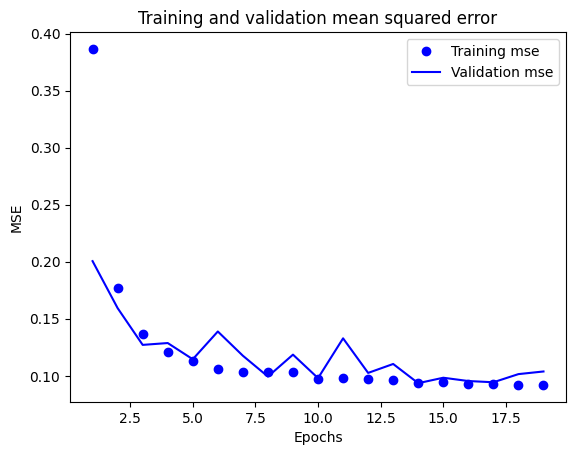

Best model loss : 0.09182457625865936
Done with model_9_4_2.
-----------------------------------------------------
Loading data for model_9_4_3...
P_matrices shape: (35000, 4, 5)
m_heights shape: (35000,)
Range of actual m_height:
Min: 75.08341
Max: 4869.5015
Generating dataset for model_9_4_3...
Range of log m_height:
Min: 4.5719395
Max: 8.4728365
Train dataset shape: (134400, 4, 5) (134400,)
Validation dataset shape: (5600, 4, 5) (5600,)
Test dataset shape: (7000, 4, 5) (7000,)
Compiling model for model_9_4_3...
Model compiled.
Training model for model_9_4_3...
Evaluating model for model_9_4_3...
Train MSE : [0.5268806219100952, 0.23545420169830322, 0.17964008450508118, 0.1536698341369629, 0.13899600505828857, 0.13503113389015198, 0.13088764250278473, 0.12642672657966614, 0.1277424395084381, 0.12363357096910477, 0.12278886884450912, 0.1191851794719696, 0.1218394860625267, 0.11934304237365723, 0.11854123324155807, 0.11689126491546631, 0.1170552596449852, 0.11677538603544235, 0.1162245

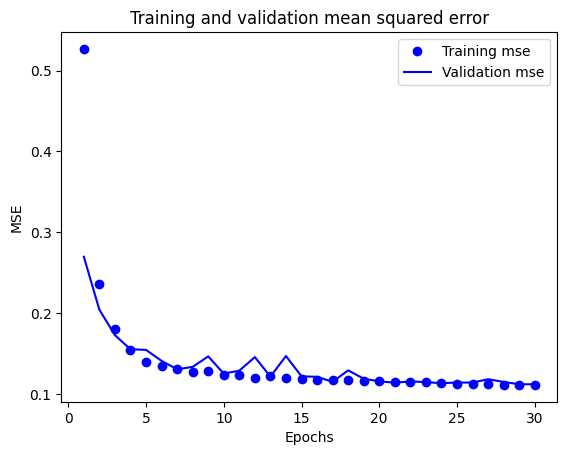

Best model loss : 0.10431172698736191
Done with model_9_4_3.
-----------------------------------------------------
Loading data for model_9_4_4...
P_matrices shape: (35000, 4, 5)
m_heights shape: (35000,)
Range of actual m_height:
Min: 182.32542
Max: 227752.38
Generating dataset for model_9_4_4...
Range of log m_height:
Min: 5.2057934
Max: 12.336015
Train dataset shape: (134400, 4, 5) (134400,)
Validation dataset shape: (5600, 4, 5) (5600,)
Test dataset shape: (7000, 4, 5) (7000,)
Compiling model for model_9_4_4...
Model compiled.
Training model for model_9_4_4...
Evaluating model for model_9_4_4...
Train MSE : [1.465207576751709, 0.679714560508728, 0.5922738313674927, 0.5186662077903748, 0.48215845227241516, 0.4651358723640442, 0.45902809500694275, 0.44825324416160583, 0.4472999572753906, 0.43533867597579956, 0.4327051341533661, 0.42849409580230713, 0.4261855483055115, 0.4236856997013092, 0.42065370082855225]
Validation MSE : [0.7441863417625427, 0.7347376942634583, 0.5162027478218079

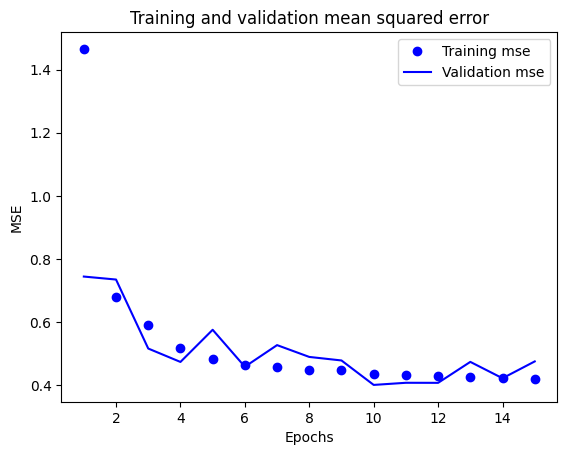

Best model loss : 0.41287046670913696
Done with model_9_4_4.
-----------------------------------------------------
Loading data for model_9_4_5...
P_matrices shape: (34999, 4, 5)
m_heights shape: (34999,)
Range of actual m_height:
Min: 1253.2301
Max: 791180800.0
Generating dataset for model_9_4_5...
Range of log m_height:
Min: 7.1334796
Max: 19.130426
Train dataset shape: (134394, 4, 5) (134394,)
Validation dataset shape: (5600, 4, 5) (5600,)
Test dataset shape: (7000, 4, 5) (7000,)
Compiling model for model_9_4_5...
Model compiled.
Training model for model_9_4_5...
Evaluating model for model_9_4_5...
Train MSE : [7.218343734741211, 2.3433172702789307, 2.2181289196014404, 2.090177059173584, 1.949704647064209, 1.8609671592712402, 1.7659229040145874, 1.7075704336166382, 1.6993204355239868, 1.6673322916030884, 1.6700284481048584, 1.654014229774475, 1.6458121538162231, 1.6514219045639038, 1.6346476078033447, 1.6331311464309692]
Validation MSE : [2.5130014419555664, 2.3511199951171875, 2.23

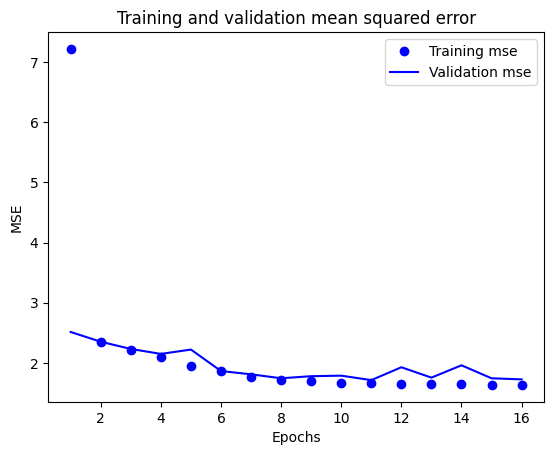

Best model loss : 1.6955140829086304
Done with model_9_4_5.
-----------------------------------------------------
Loading data for model_9_5_2...
P_matrices shape: (60000, 5, 4)
m_heights shape: (60000,)
Range of actual m_height:
Min: 59.612354
Max: 5430.9243
Generating dataset for model_9_5_2...
Range of log m_height:
Min: 4.087863
Max: 8.599865
Train dataset shape: (230400, 5, 4) (230400,)
Validation dataset shape: (9600, 5, 4) (9600,)
Test dataset shape: (12000, 5, 4) (12000,)
Compiling model for model_9_5_2...
Model compiled.
Training model for model_9_5_2...
Evaluating model for model_9_5_2...
Train MSE : [0.5624315142631531, 0.20547977089881897, 0.15459364652633667, 0.13524557650089264, 0.12459169328212738, 0.12165788561105728, 0.11693073809146881, 0.11410614103078842, 0.11243906617164612, 0.11039772629737854, 0.10902465134859085, 0.10780732333660126, 0.10736367851495743, 0.10613338649272919, 0.10599339008331299, 0.10531813651323318, 0.10498938709497452, 0.10467448830604553, 0.10

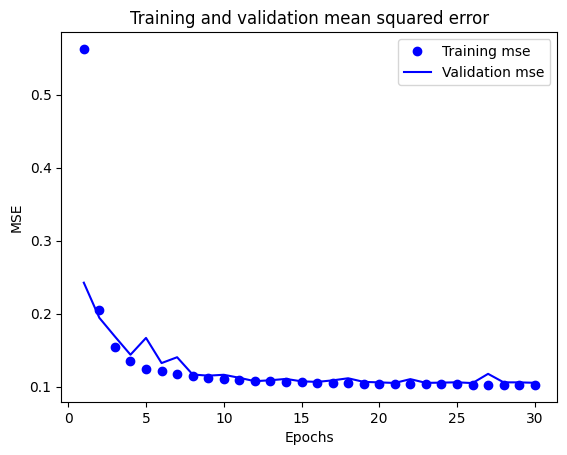

Best model loss : 0.10491675138473511
Done with model_9_5_2.
-----------------------------------------------------
Loading data for model_9_5_3...
P_matrices shape: (60000, 5, 4)
m_heights shape: (60000,)
Range of actual m_height:
Min: 217.01117
Max: 405500.7
Generating dataset for model_9_5_3...
Range of log m_height:
Min: 5.3816857
Max: 12.912878
Train dataset shape: (230400, 5, 4) (230400,)
Validation dataset shape: (9600, 5, 4) (9600,)
Test dataset shape: (12000, 5, 4) (12000,)
Compiling model for model_9_5_3...
Model compiled.
Training model for model_9_5_3...
Evaluating model for model_9_5_3...
Train MSE : [1.193906545639038, 0.5944929718971252, 0.5060204267501831, 0.45941752195358276, 0.44024932384490967, 0.4318740963935852, 0.4235370457172394, 0.4200235903263092, 0.4140055477619171, 0.41183537244796753, 0.4059814512729645, 0.40465012192726135, 0.4018010199069977, 0.40072014927864075]
Validation MSE : [0.6650329828262329, 0.5250868201255798, 0.46335068345069885, 0.44172677397727

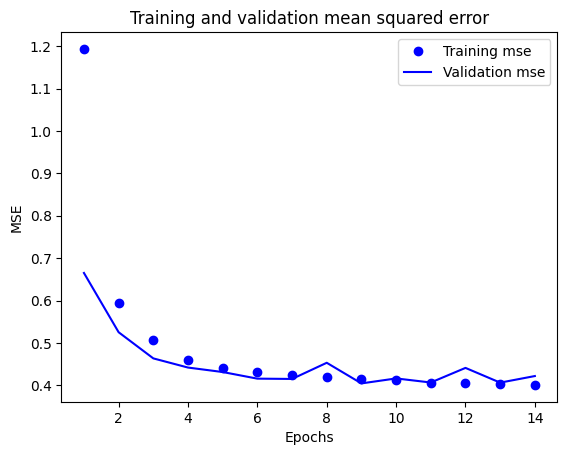

Best model loss : 0.4046470522880554
Done with model_9_5_3.
-----------------------------------------------------
Loading data for model_9_5_4...
P_matrices shape: (59992, 5, 4)
m_heights shape: (59992,)
Range of actual m_height:
Min: 1291.7003
Max: 293406800.0
Generating dataset for model_9_5_4...
Range of log m_height:
Min: 7.163715
Max: 18.92264
Train dataset shape: (230364, 5, 4) (230364,)
Validation dataset shape: (9599, 5, 4) (9599,)
Test dataset shape: (11999, 5, 4) (11999,)
Compiling model for model_9_5_4...
Model compiled.
Training model for model_9_5_4...
Evaluating model for model_9_5_4...
Train MSE : [2.602335214614868, 2.0697221755981445, 1.9049255847930908, 1.8025273084640503, 1.7498193979263306, 1.7218412160873413, 1.7070112228393555, 1.6954846382141113, 1.6883076429367065, 1.684618592262268, 1.680267333984375, 1.6772804260253906, 1.67206609249115, 1.6747260093688965, 1.6700142621994019, 1.67008638381958, 1.6645036935806274, 1.6682714223861694, 1.663559079170227, 1.66189

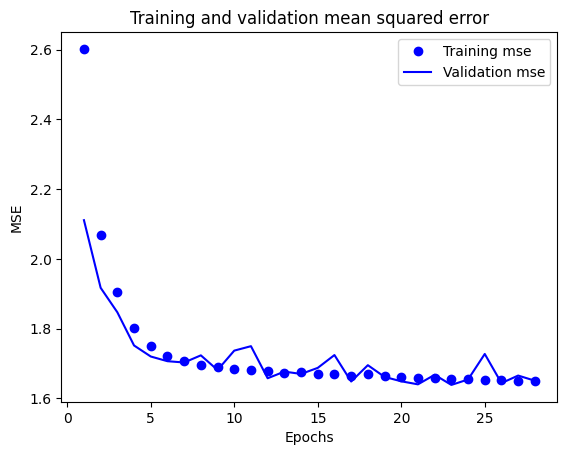

Best model loss : 1.6865743398666382
Done with model_9_5_4.
-----------------------------------------------------
Loading data for model_9_6_2...
P_matrices shape: (60000, 6, 3)
m_heights shape: (60000,)
Range of actual m_height:
Min: 179.31691
Max: 74019.02
Generating dataset for model_9_6_2...
Range of log m_height:
Min: 5.1891546
Max: 11.212077
Train dataset shape: (230400, 6, 3) (230400,)
Validation dataset shape: (9600, 6, 3) (9600,)
Test dataset shape: (12000, 6, 3) (12000,)
Compiling model for model_9_6_2...
Model compiled.
Training model for model_9_6_2...
Evaluating model for model_9_6_2...
Train MSE : [1.3419148921966553, 0.5019318461418152, 0.3952081501483917, 0.34704843163490295, 0.32355645298957825, 0.30629459023475647, 0.29990285634994507, 0.29324984550476074, 0.2890314757823944, 0.2844371795654297, 0.28172269463539124, 0.27846166491508484, 0.2763088047504425, 0.27382007241249084, 0.2718067765235901, 0.2691454291343689, 0.26691508293151855, 0.26446816325187683, 0.26214635

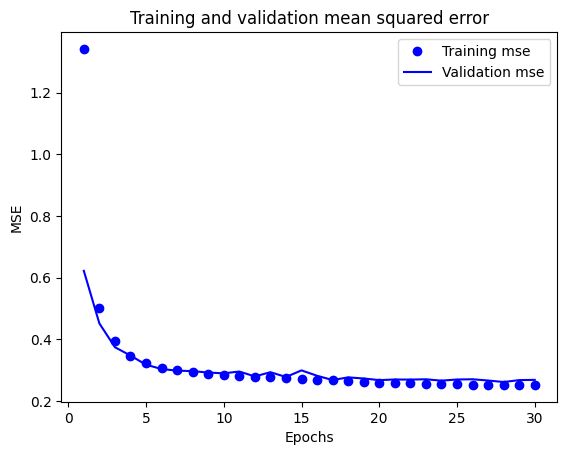

Best model loss : 0.26168352365493774
Done with model_9_6_2.
-----------------------------------------------------
Loading data for model_9_6_3...
P_matrices shape: (59998, 6, 3)
m_heights shape: (59998,)
Range of actual m_height:
Min: 797.8311
Max: 304307800.0
Generating dataset for model_9_6_3...
Range of log m_height:
Min: 6.681897
Max: 19.324318
Train dataset shape: (230388, 6, 3) (230388,)
Validation dataset shape: (9600, 6, 3) (9600,)
Test dataset shape: (12000, 6, 3) (12000,)
Compiling model for model_9_6_3...
Model compiled.
Training model for model_9_6_3...
Evaluating model for model_9_6_3...
Train MSE : [3.1448898315429688, 2.0949862003326416, 1.907989740371704, 1.7867265939712524, 1.7242951393127441, 1.6878955364227295, 1.6715682744979858, 1.6610467433929443, 1.6476619243621826, 1.6462374925613403, 1.6435837745666504, 1.6410316228866577, 1.63763427734375, 1.6336718797683716, 1.6290550231933594, 1.6279845237731934, 1.6254456043243408, 1.6232857704162598, 1.6231621503829956, 1

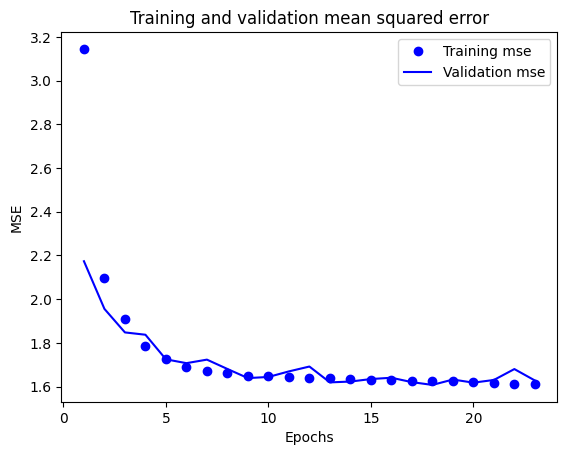

Best model loss : 1.6398515701293945
Done with model_9_6_3.
-----------------------------------------------------
Loading data for model_10_4_2...
P_matrices shape: (35000, 4, 6)
m_heights shape: (35000,)
Range of actual m_height:
Min: 7.893224
Max: 290.02396
Generating dataset for model_10_4_2...
Range of log m_height:
Min: 2.14672
Max: 5.6699634
Train dataset shape: (134400, 4, 6) (134400,)
Validation dataset shape: (5600, 4, 6) (5600,)
Test dataset shape: (7000, 4, 6) (7000,)
Compiling model for model_10_4_2...
Model compiled.
Training model for model_10_4_2...
Evaluating model for model_10_4_2...
Train MSE : [0.7279257774353027, 0.5403313636779785, 0.4975384771823883, 0.4737873375415802, 0.462716281414032, 0.45377692580223083, 0.44882985949516296, 0.44173818826675415, 0.43756505846977234, 0.432991087436676, 0.43164706230163574, 0.4276364743709564, 0.4296285808086395, 0.42503058910369873, 0.42198941111564636, 0.424655020236969, 0.41843336820602417, 0.4181886315345764]
Validation MSE

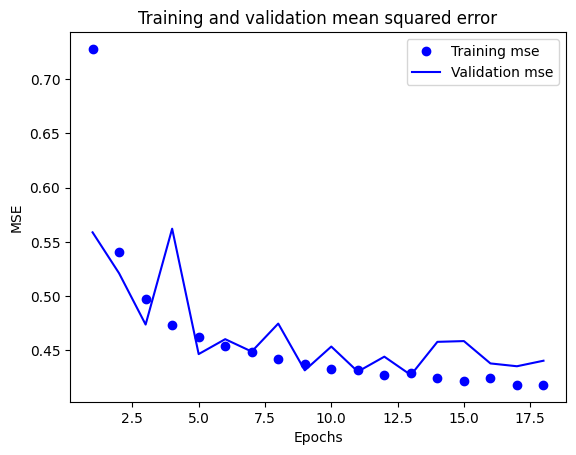

Best model loss : 0.4288865923881531
Done with model_10_4_2.
-----------------------------------------------------
Loading data for model_10_4_3...
P_matrices shape: (35000, 4, 6)
m_heights shape: (35000,)
Range of actual m_height:
Min: 43.2334
Max: 1371.838
Generating dataset for model_10_4_3...
Range of log m_height:
Min: 3.8820205
Max: 7.2239065
Train dataset shape: (134400, 4, 6) (134400,)
Validation dataset shape: (5600, 4, 6) (5600,)
Test dataset shape: (7000, 4, 6) (7000,)
Compiling model for model_10_4_3...
Model compiled.
Training model for model_10_4_3...
Evaluating model for model_10_4_3...
Train MSE : [0.7272681593894958, 0.18057729303836823, 0.13389992713928223, 0.09902437031269073, 0.0783955380320549, 0.0730026513338089, 0.06818139553070068, 0.06343481689691544, 0.06540516763925552, 0.05993983522057533, 0.05968836694955826, 0.058460865169763565, 0.05773618072271347, 0.05744674429297447, 0.05648686736822128, 0.05599486827850342, 0.05534898117184639, 0.053312353789806366, 0

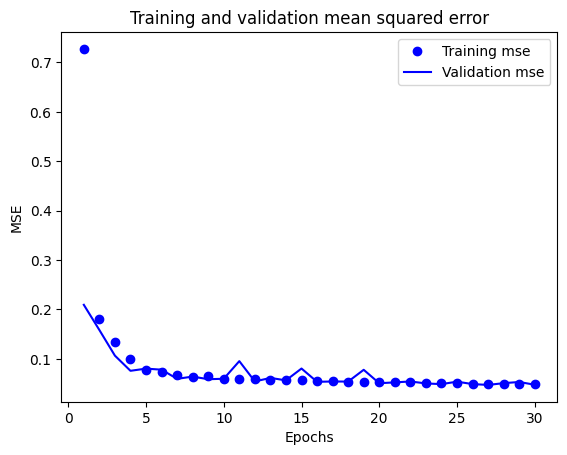

Best model loss : 0.047600120306015015
Done with model_10_4_3.
-----------------------------------------------------
Loading data for model_10_4_4...
P_matrices shape: (35000, 4, 6)
m_heights shape: (35000,)
Range of actual m_height:
Min: 124.328674
Max: 8479.153
Generating dataset for model_10_4_4...
Range of log m_height:
Min: 4.822929
Max: 9.045366
Train dataset shape: (134400, 4, 6) (134400,)
Validation dataset shape: (5600, 4, 6) (5600,)
Test dataset shape: (7000, 4, 6) (7000,)
Compiling model for model_10_4_4...
Model compiled.
Training model for model_10_4_4...
Evaluating model for model_10_4_4...
Train MSE : [1.1826518774032593, 0.312741756439209, 0.25905320048332214, 0.21145138144493103, 0.18072642385959625, 0.16308221220970154, 0.15212208032608032, 0.14528898894786835, 0.14539958536624908, 0.1415777951478958, 0.14084595441818237, 0.13848894834518433, 0.13648360967636108, 0.1368778944015503]
Validation MSE : [0.34678322076797485, 0.2905496060848236, 0.2309487909078598, 0.21629

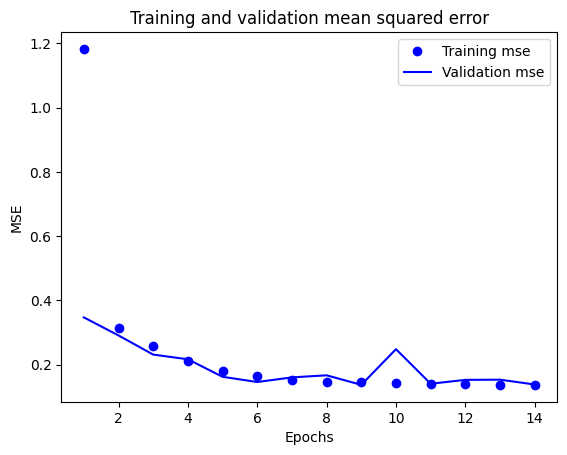

Best model loss : 0.13828358054161072
Done with model_10_4_4.
-----------------------------------------------------
Loading data for model_10_4_5...
P_matrices shape: (35000, 4, 6)
m_heights shape: (35000,)
Range of actual m_height:
Min: 241.41588
Max: 251195.02
Generating dataset for model_10_4_5...
Range of log m_height:
Min: 5.4865212
Max: 12.395532
Train dataset shape: (134400, 4, 6) (134400,)
Validation dataset shape: (5600, 4, 6) (5600,)
Test dataset shape: (7000, 4, 6) (7000,)
Compiling model for model_10_4_5...
Model compiled.
Training model for model_10_4_5...
Evaluating model for model_10_4_5...
Train MSE : [1.3929826021194458, 0.6940969824790955, 0.6206170916557312, 0.5615032315254211, 0.517037570476532, 0.48832979798316956, 0.4759059250354767, 0.4684321880340576, 0.4570120871067047, 0.4518581032752991, 0.4585787355899811, 0.447396844625473, 0.4456879794597626, 0.4453735649585724, 0.4425555467605591, 0.43899598717689514, 0.43984541296958923, 0.4389617443084717, 0.43572631478

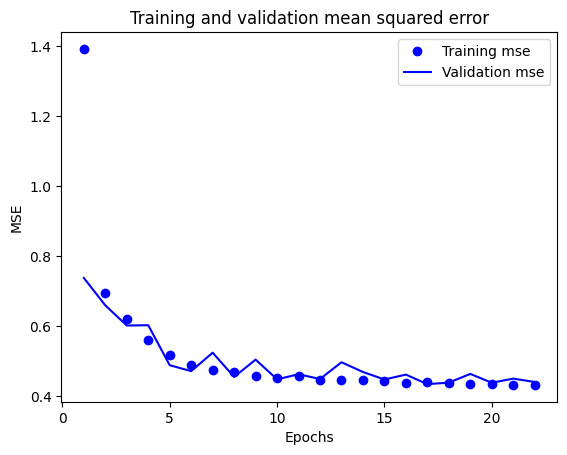

Best model loss : 0.43679454922676086
Done with model_10_4_5.
-----------------------------------------------------
Loading data for model_10_4_6...
P_matrices shape: (34999, 4, 6)
m_heights shape: (34999,)
Range of actual m_height:
Min: 1932.9349
Max: 602061760.0
Generating dataset for model_10_4_6...
Range of log m_height:
Min: 7.566795
Max: 20.21587
Train dataset shape: (134394, 4, 6) (134394,)
Validation dataset shape: (5600, 4, 6) (5600,)
Test dataset shape: (7000, 4, 6) (7000,)
Compiling model for model_10_4_6...
Model compiled.
Training model for model_10_4_6...
Evaluating model for model_10_4_6...
Train MSE : [3.037407159805298, 2.266383409500122, 2.106945276260376, 1.9668703079223633, 1.8628926277160645, 1.802840232849121, 1.7661495208740234, 1.7376734018325806, 1.7112737894058228, 1.711564540863037, 1.7020961046218872, 1.700179100036621, 1.6943877935409546, 1.6834909915924072, 1.6743686199188232, 1.6869621276855469, 1.678105354309082]
Validation MSE : [2.409031867980957, 2.27

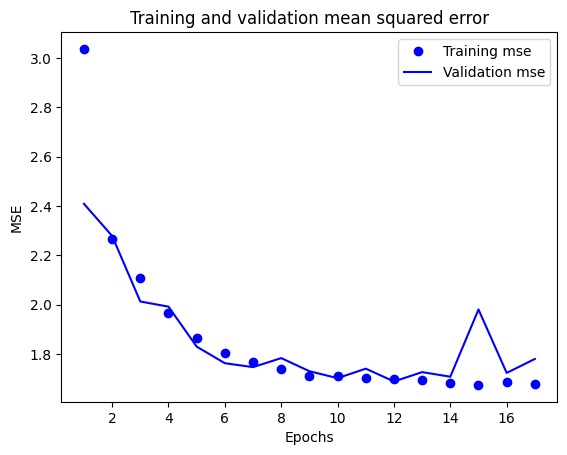

Best model loss : 1.7631778717041016
Done with model_10_4_6.
-----------------------------------------------------
Loading data for model_10_5_2...
P_matrices shape: (35000, 5, 5)
m_heights shape: (35000,)
Range of actual m_height:
Min: 45.804024
Max: 1402.43
Generating dataset for model_10_5_2...
Range of log m_height:
Min: 3.824372
Max: 7.2459617
Train dataset shape: (134400, 5, 5) (134400,)
Validation dataset shape: (5600, 5, 5) (5600,)
Test dataset shape: (7000, 5, 5) (7000,)
Compiling model for model_10_5_2...
Model compiled.
Training model for model_10_5_2...
Evaluating model for model_10_5_2...
Train MSE : [1.2997441291809082, 0.24009758234024048, 0.18448494374752045, 0.14587987959384918, 0.12214451283216476, 0.10130787640810013, 0.08733876049518585, 0.08226177096366882, 0.07641474157571793, 0.07359316200017929, 0.06977781653404236, 0.06917615979909897, 0.06794223189353943, 0.06618918478488922, 0.06480483710765839, 0.0648982897400856, 0.06366802006959915, 0.06172388792037964, 0.

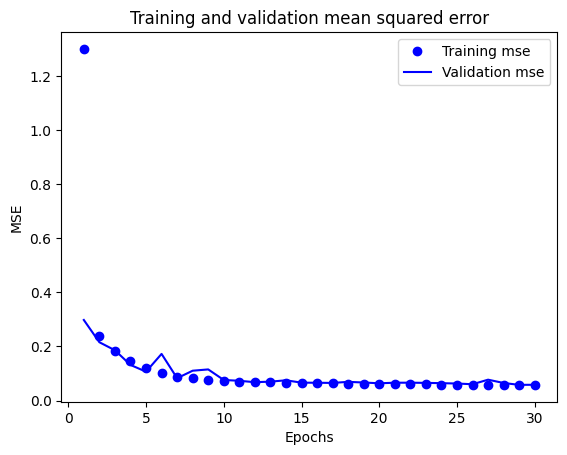

Best model loss : 0.05826064199209213
Done with model_10_5_2.
-----------------------------------------------------
Loading data for model_10_5_3...
P_matrices shape: (35000, 5, 5)
m_heights shape: (35000,)
Range of actual m_height:
Min: 135.14496
Max: 15339.225
Generating dataset for model_10_5_3...
Range of log m_height:
Min: 4.9063478
Max: 9.106428
Train dataset shape: (134400, 5, 5) (134400,)
Validation dataset shape: (5600, 5, 5) (5600,)
Test dataset shape: (7000, 5, 5) (7000,)
Compiling model for model_10_5_3...
Model compiled.
Training model for model_10_5_3...
Evaluating model for model_10_5_3...
Train MSE : [1.051382064819336, 0.3527885377407074, 0.287339448928833, 0.23830144107341766, 0.21238961815834045, 0.19779996573925018, 0.1901121884584427, 0.17855218052864075, 0.17769049108028412, 0.17334775626659393, 0.1710127592086792, 0.16659659147262573, 0.1645129770040512, 0.1656525433063507, 0.16203869879245758, 0.16142237186431885, 0.1617473065853119, 0.15954464673995972, 0.15946

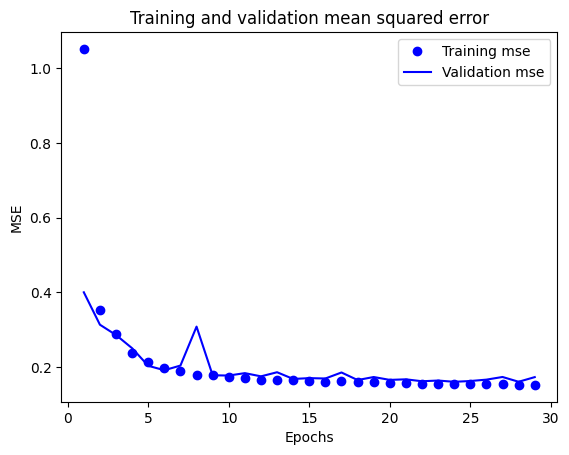

Best model loss : 0.15701495110988617
Done with model_10_5_3.
-----------------------------------------------------
Loading data for model_10_5_4...
P_matrices shape: (35000, 5, 5)
m_heights shape: (35000,)
Range of actual m_height:
Min: 346.75046
Max: 605281.9
Generating dataset for model_10_5_4...
Range of log m_height:
Min: 5.848605
Max: 13.31345
Train dataset shape: (134400, 5, 5) (134400,)
Validation dataset shape: (5600, 5, 5) (5600,)
Test dataset shape: (7000, 5, 5) (7000,)
Compiling model for model_10_5_4...
Model compiled.
Training model for model_10_5_4...
Evaluating model for model_10_5_4...
Train MSE : [2.2169198989868164, 0.7747269868850708, 0.679087221622467, 0.6246590614318848, 0.5686161518096924, 0.538784921169281, 0.5223512649536133, 0.501655101776123, 0.49557507038116455, 0.48261457681655884, 0.47640717029571533, 0.47238820791244507, 0.47163495421409607, 0.4621424078941345, 0.4674762785434723, 0.4572002589702606, 0.45578765869140625, 0.4562819302082062]
Validation MSE

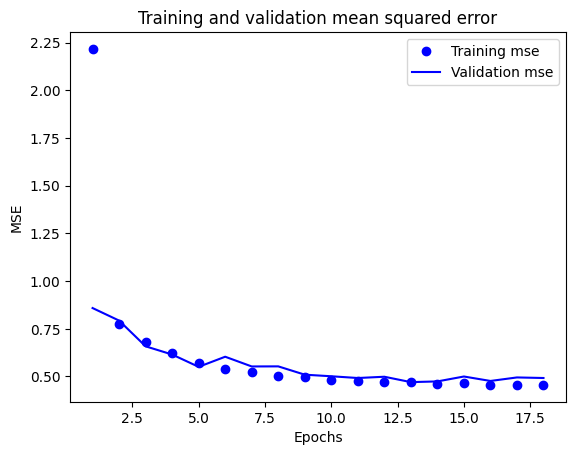

Best model loss : 0.45844700932502747
Done with model_10_5_4.
-----------------------------------------------------
Loading data for model_10_5_5...
P_matrices shape: (34996, 5, 5)
m_heights shape: (34996,)
Range of actual m_height:
Min: 3788.6633
Max: 2212130300.0
Generating dataset for model_10_5_5...
Range of log m_height:
Min: 8.239769
Max: 21.517221
Train dataset shape: (134376, 5, 5) (134376,)
Validation dataset shape: (5600, 5, 5) (5600,)
Test dataset shape: (7000, 5, 5) (7000,)
Compiling model for model_10_5_5...
Model compiled.
Training model for model_10_5_5...
Evaluating model for model_10_5_5...
Train MSE : [3.43090558052063, 2.2685132026672363, 2.1081647872924805, 1.9748408794403076, 1.8979798555374146, 1.8457657098770142, 1.7681841850280762, 1.7667217254638672, 1.7338486909866333, 1.7190356254577637, 1.7056974172592163, 1.687404990196228, 1.6822923421859741, 1.6698311567306519, 1.6781233549118042, 1.664426326751709, 1.6606204509735107, 1.6575846672058105, 1.66015279293060

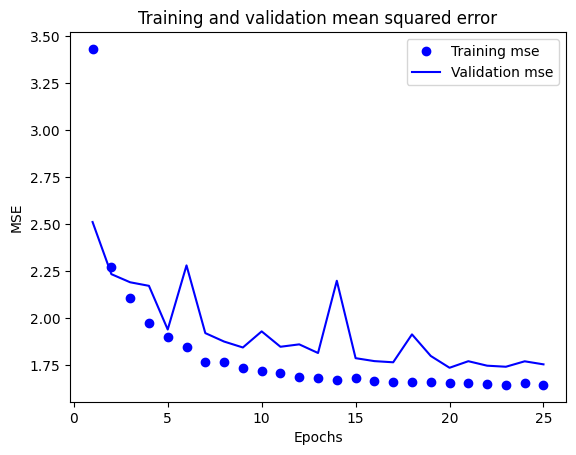

Best model loss : 1.6894320249557495
Done with model_10_5_5.
-----------------------------------------------------
Loading data for model_10_6_2...
P_matrices shape: (35000, 6, 4)
m_heights shape: (35000,)
Range of actual m_height:
Min: 121.08272
Max: 8176.3545
Generating dataset for model_10_6_2...
Range of log m_height:
Min: 4.9667716
Max: 9.009002
Train dataset shape: (134400, 6, 4) (134400,)
Validation dataset shape: (5600, 6, 4) (5600,)
Test dataset shape: (7000, 6, 4) (7000,)
Compiling model for model_10_6_2...
Model compiled.
Training model for model_10_6_2...
Evaluating model for model_10_6_2...
Train MSE : [1.3142962455749512, 0.36383169889450073, 0.2649480402469635, 0.214046910405159, 0.18270739912986755, 0.1622663289308548, 0.14869117736816406, 0.13789983093738556, 0.13338401913642883, 0.12805067002773285, 0.127482607960701, 0.1231498196721077, 0.12014114111661911, 0.11998993158340454, 0.11761393398046494, 0.11684826016426086, 0.11693572252988815, 0.11543295532464981, 0.1139

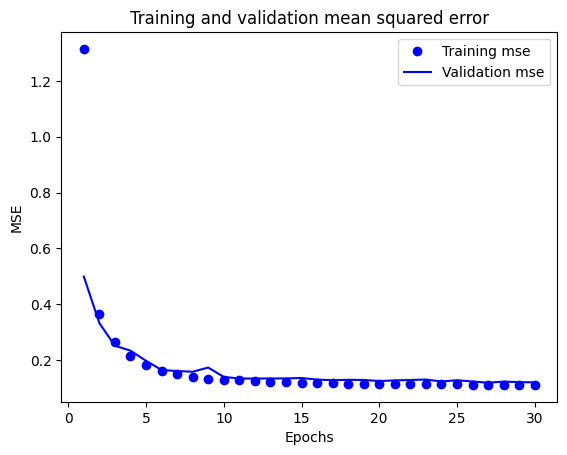

Best model loss : 0.12359418720006943
Done with model_10_6_2.
-----------------------------------------------------
Loading data for model_10_6_3...
P_matrices shape: (35000, 6, 4)
m_heights shape: (35000,)
Range of actual m_height:
Min: 301.86646
Max: 363804.8
Generating dataset for model_10_6_3...
Range of log m_height:
Min: 5.709985
Max: 12.804373
Train dataset shape: (134400, 6, 4) (134400,)
Validation dataset shape: (5600, 6, 4) (5600,)
Test dataset shape: (7000, 6, 4) (7000,)
Compiling model for model_10_6_3...
Model compiled.
Training model for model_10_6_3...
Evaluating model for model_10_6_3...
Train MSE : [1.5955039262771606, 0.7192263007164001, 0.6086840629577637, 0.5412593483924866, 0.5019316673278809, 0.4744521975517273, 0.4584631323814392, 0.4452041983604431, 0.4377751052379608, 0.43333354592323303, 0.42591238021850586, 0.42510315775871277, 0.41704875230789185, 0.41827428340911865, 0.41554057598114014, 0.41310766339302063, 0.41315603256225586, 0.4106903374195099, 0.408587

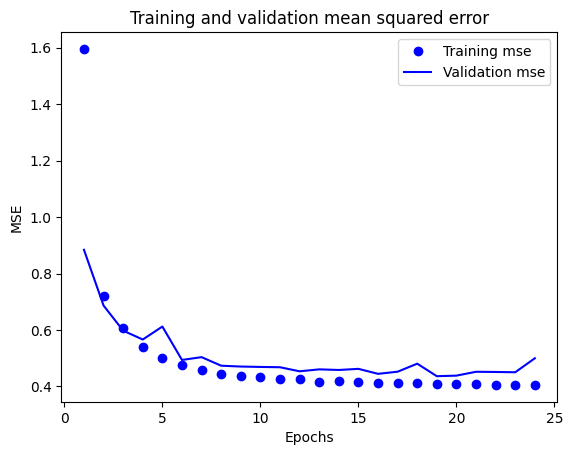

Best model loss : 0.43645933270454407
Done with model_10_6_3.
-----------------------------------------------------
Loading data for model_10_6_4...
P_matrices shape: (34993, 6, 4)
m_heights shape: (34993,)
Range of actual m_height:
Min: 2049.033
Max: 149345460.0
Generating dataset for model_10_6_4...
Range of log m_height:
Min: 7.625123
Max: 18.764399
Train dataset shape: (134370, 6, 4) (134370,)
Validation dataset shape: (5599, 6, 4) (5599,)
Test dataset shape: (6999, 6, 4) (6999,)
Compiling model for model_10_6_4...
Model compiled.
Training model for model_10_6_4...
Evaluating model for model_10_6_4...
Train MSE : [5.030585765838623, 2.4745376110076904, 2.264765501022339, 2.1185522079467773, 2.001460313796997, 1.923762559890747, 1.8408091068267822, 1.8034999370574951, 1.7618764638900757, 1.7348417043685913, 1.7169057130813599, 1.6943154335021973, 1.6926960945129395, 1.6682482957839966, 1.66513991355896, 1.6644352674484253, 1.6504417657852173, 1.661111831665039, 1.6390995979309082, 1

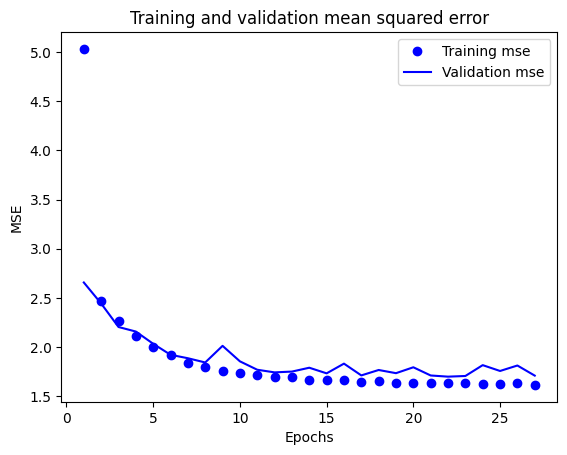

Best model loss : 1.6876481771469116
Done with model_10_6_4.
-----------------------------------------------------


In [13]:
model_save_directory = "model_11"
val_split = 0.2
test_split = 0.2
num_permutations = 5
batch_size = 128
random_state = np.random.randint(0, 10000)
epochs = 30
patience = 5
train_verbosity = 0
for model_name, model_info in models_dict.items():
    # if model_name != "model_1":
    #     break
    filepath = samples_filepath + model_info['file_name']
    n = model_info['n']
    k = model_info['k']
    m = model_info['m']
    model_info['model'] = CustomModel(n=n, k=k, m=m)
    print(f"Loading data for model_{n}_{k}_{m}...")
    model_info['model'].load_and_preprocess_data(filepath)
    print(f"Generating dataset for model_{n}_{k}_{m}...")
    model_info['model'].train_test_val_split(val_split=val_split, test_split=test_split, num_permutations=num_permutations, batch_size=batch_size, random_state=random_state)
    print(f"Compiling model for model_{n}_{k}_{m}...")
    model_info['model'].model_compile(build_model, print_summary=False)
    # plot_model(model_info['model'].model, show_shapes=True, show_layer_names=True)
    print(f"Training model for model_{n}_{k}_{m}...")
    model_info['model'].model_train(epochs=epochs, verbose=train_verbosity, patience=patience, model_save_directory = model_save_directory)
    print(f"Evaluating model for model_{n}_{k}_{m}...")
    model_info['model'].plot_history()
    model_info['model'].evaluate_model(batch_size=batch_size)
    print(f"Done with model_{n}_{k}_{m}.")
    print("-----------------------------------------------------")

eval_inputs_combined = {}
eval_outputs_combined = {}

for model_name, model_info in models_dict.items():
    # if model_name != "model_1":
    #     break
    for key in model_info['model'].eval_inputs.keys():
        if key not in eval_inputs_combined:
            eval_inputs_combined[key] = []
        eval_inputs_combined[key].extend(model_info['model'].eval_inputs[key])
    for key in model_info['model'].eval_outputs.keys():
        if key not in eval_outputs_combined:
            eval_outputs_combined[key] = []
        eval_outputs_combined[key].extend(model_info['model'].eval_outputs[key])

with gzip.open(model_save_directory+'/eval_inputs_combined', 'wb') as f:
            pickle.dump(eval_inputs_combined, f)
with gzip.open(model_save_directory+'/eval_outputs_combined', 'wb') as f:
            pickle.dump(eval_outputs_combined, f)


In [14]:
from tamu_csce_636_project1 import Evaluator
evaluator = Evaluator(
    first_name="Your Name",
    last_name="Your Name",
    email="email@tamu.edu",
    print=False,
)

In [52]:
# flag = True
def predict_and_evaluate(n,k,m,P_matrices):
    ## load model
    model_name = model_save_directory + '/' + f'model_{n}_{k}_{m}.keras'
    model = tf.keras.models.load_model(model_name)
    m_heights = []
    P_matrices = np.array(P_matrices, dtype=np.float32)
    m_heights_pred = model.predict(P_matrices.reshape(len(P_matrices), k, n-k), verbose=0)
    m_heights = [np.exp(m_heights_pred[i][0]) for i in range(len(m_heights_pred))]
    # if True:
    #     print("m_heights_pred shape:", m_heights_pred.shape)
    #     print('m_heights_pred:', m_heights_pred)
    #     print('m_heights:', m_heights)
        # flag = False
    # m_heights = np.exp(m_heights_pred[0])
    # print(P_matrices[0])
    # print(m_heights_pred[0])
    # print(m_heights_pred[0][m-1])
    # print(np.exp(m_heights_pred[0][m-1]))
    # print(m_heights[0])
    return m_heights

In [53]:
eval_inputs_combined = {}
eval_outputs_combined = {}

for model_name, model_info in models_dict.items():
    # if model_name != "model_1":
    #     break
    for key in model_info['model'].eval_inputs.keys():
        if key not in eval_inputs_combined:
            eval_inputs_combined[key] = []
        eval_inputs_combined[key].extend(model_info['model'].eval_inputs[key])
    for key in model_info['model'].eval_outputs.keys():
        if key not in eval_outputs_combined:
            eval_outputs_combined[key] = []
        eval_outputs_combined[key].extend(model_info['model'].eval_outputs[key])

with gzip.open(model_save_directory+'/eval_inputs_combined', 'wb') as f:
            pickle.dump(eval_inputs_combined, f)
with gzip.open(model_save_directory+'/eval_outputs_combined', 'wb') as f:
            pickle.dump(eval_outputs_combined, f)

In [54]:
model_save_directory = "model_11"
with gzip.open(model_save_directory+'/eval_inputs_combined', 'rb') as f:
    eval_inputs_combined = pickle.load(f)
with gzip.open(model_save_directory+'/eval_outputs_combined', 'rb') as f:
    eval_outputs_combined = pickle.load(f)
σ = evaluator.eval(
        inputs=eval_inputs_combined,
        outputs=eval_outputs_combined,
        func=predict_and_evaluate,
    )
average_σ = sum(σ.values()) / len(σ) if σ else 0
print(f"Average σ: {average_σ}")
for key, value in σ.items():
    print(f"{key}, σ: {value}")

Average σ: 1.3705113390493397
(9, 4, 2), σ: 0.1911207799041712
(9, 4, 3), σ: 0.2171111752316615
(9, 4, 4), σ: 0.8593356033349774
(9, 4, 5), σ: 3.5289903051186298
(9, 5, 2), σ: 0.21837050525062898
(9, 5, 3), σ: 0.842219837098582
(9, 5, 4), σ: 3.510383622997153
(9, 6, 2), σ: 0.5446600248011305
(9, 6, 3), σ: 3.4131355267827934
(10, 4, 2), σ: 0.892671191126852
(10, 4, 3), σ: 0.09907341835208042
(10, 4, 4), σ: 0.28781911779961705
(10, 4, 5), σ: 0.9091304111492386
(10, 4, 6), σ: 3.6698235595199984
(10, 5, 2), σ: 0.12126188654769789
(10, 5, 3), σ: 0.3268060556992906
(10, 5, 4), σ: 0.9541972311154385
(10, 5, 5), σ: 3.516331805684602
(10, 6, 2), σ: 0.25724504853493274
(10, 6, 3), σ: 0.9084328839903085
(10, 6, 4), σ: 3.5126181299963513
